In [1]:
from environment import Market, get_ts
from model import Q_Model
from agent import Agent
from simulator import Simulator
from visualization import Visualize
import pandas as pd
import matplotlib.pyplot as plt

# sampler = Single_Signal_Generator(total_timesteps=180, period_range=(10, 40), amplitude_range=(5, 80), noise_amplitude_ratio=0.5)
# filename = "Generated Signals.npy"
# sampler.build_signals(filename, 1000)
# sampler.load(filename)
# env = Market(sampler=sampler, last_n_timesteps=40, trans_cost=3.3)

# ticker=['MS']
# ticker=['TSLA']
# ticker=['TSLA', 'GOOGL', 'MS', 'KO', 'CVX', 'HD', 'MMM' ,'BA']
# sample = get_ts(ticker)
# sample.to_csv('data/test/test_data_8stockmix.csv')
sample = pd.read_csv('data/test/test_data_8stockmix.csv', index_col=0)
# sample = pd.read_csv('data/test/test_data.csv', index_col=0)
print(sample.head())
# print(sample.shape)
# print(sample.dtypes)
env_train = Market(sample.iloc[:1500, :], 20, 0.5)
env_test = Market(sample.iloc[1500:, :], 20, 0.5)
# env.reset()

dense_model = [
    {"type":"Reshape", "target_shape":(env_train.get_state().shape[0]*env_train.get_state().shape[1],)},
    {"type":"Dense", "units":64*env_train.get_state().shape[1]},
    {"type":"Dense", "units":64}
]
conv_model = [
    {"type":"Reshape", "target_shape":env_train.get_state().shape},
    {"type":"Conv1D", "filters":16, "kernel_size":3, "activation":"relu"},
    {"type":"Conv1D", "filters":16, "kernel_size":3, "activation":"relu"},
    {"type":"Flatten"},
    {"type":"Dense", "units":48, "activation":"relu"},
    {"type":"Dense", "units":24, "activation":"relu"}
]
gru_model = [
    {"type":"Reshape", "target_shape":env_train.get_state().shape},
    {"type":"GRU", "units":16, "return_sequences":True},
    {"type":"GRU", "units":16, "return_sequences":False},
    {"type":"Dense", "units":16, "activation":"relu"},
    # {"type":"Dense", "units":16, "activation":"relu"}
]
lstm_model = [
    {"type":"Reshape", "target_shape":env_train.get_state().shape},
    {"type":"LSTM", "units":16, "return_sequences":True},
    {"type":"LSTM", "units":16, "return_sequences":False},
    {"type":"Dense", "units":16, "activation":"relu"},
    # {"type":"Dense", "units":16, "activation":"relu"}
]

# user input
no_epochs = 250
model_name = 'Dense_8stock_longonly_ewa'
run_details = model_name + '_' + str(no_epochs) + '_eps'
learning_rate = 0.0001
# experience replay batch_size = 16

# build model and agent
q_model = Q_Model(model_name, state_dim=env_train.get_state().shape, no_of_actions=env_train.no_of_actions, layers=dense_model, hyperparameters={"lr":learning_rate})
agent = Agent(q_model, batch_size=8, discount_factor=0.995, epsilon=0.7)

# train and test
sim = Simulator(env_train, agent)
ep_end_portf_val_train, last_eps_position_ts_train, exploration_episode_rewards_train, episode_ending_losses = sim.train(no_epochs, epsilon_decay=0.995)

# save model snapshot 
agent.model.save() 

sim_test = Simulator(env_test, agent)
test_portf_val_ts, test_position_ts, test_ending_rewards = sim_test.test()

# visualize result
viz = Visualize(env_train, env_test, ep_end_portf_val_train, exploration_episode_rewards_train, episode_ending_losses, run_details)
viz.save_test_results()

Using TensorFlow backend.
  0%|          | 0/250 [00:00<?, ?it/s]

             TSLA     GOOGL       MS      IBM       KO      CVX       HD  \
date                                                                       
2010-06-29  23.89  227.8333  20.1909  94.0708  18.8046  47.9884  22.9363   
2010-06-30  23.83  223.1639  19.9843  92.8600  18.7262  47.6374  22.4877   
2010-07-01  21.96  220.4254  19.8809  92.1757  18.6925  47.3706  22.3675   
2010-07-02  19.20  218.9509  19.6571  91.6417  18.7000  47.2513  22.2393   
2010-07-06  16.11  218.7101  19.7776  92.8450  18.8420  47.4268  21.9029   

                MCD  
date                 
2010-06-29  50.1788  
2010-06-30  49.7334  
2010-07-01  50.3676  
2010-07-02  49.9372  
2010-07-06  49.9146  
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)            

  0%|          | 0/1 [00:00<?, ?it/s]

------------------------------------------------------------
Testing
------------------------------------------------------------


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


best stock pick:  MS


<Figure size 1200x800 with 1 Axes>

<Figure size 1200x800 with 1 Axes>

<Figure size 1200x800 with 1 Axes>

<Figure size 1200x800 with 1 Axes>

<Figure size 1200x800 with 1 Axes>

<Figure size 1200x800 with 1 Axes>

<Figure size 1200x800 with 1 Axes>

<Figure size 1200x800 with 1 Axes>

<Figure size 1200x800 with 1 Axes>

(-10000000, 10000000)

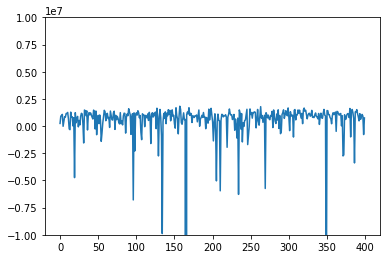

In [9]:
import numpy as np
plt.plot(np.sum(np.array(exploration_episode_rewards_train), axis=1))
plt.ylim(-10000000, 10000000)